# FEATURE EXTRACTION NOTEBOOK

Feature extraction refers to the process of transforming raw data into features that can be processed while preserving the information in the original data set. It yields better results than applying machine learning directly to the raw data.

So far, we have done a bit of preprocessing using some image processing techniques. We have taken the open-cv libraries into account to apply such preprocessing. 
The resulting images have been archived into the dataset folder and transferred to google drive.

## PREPARATION
In the following, we are going to set some constants in order to use them later on. We also have mounting google drive in order to save the training logs into our g-drive.

### MOUNTING GOOGLE DRIVE
The first thing to do is to give google colab permission to access our drive so as to save the training checkpoints.

In [81]:
#MOUNTING GOOGLE DRIVE

from google.colab import drive
drive.mount('/content/gdrive',  force_remount=True) 

# force_remount is an argument to force google drive to mount once again.

Mounted at /content/gdrive


### DOWNLOAD The DATASET

Once we have finished our preprocessing, we have created a `dataset.zip` file from all the raw images. Now we download this file from our drive in order to start the training phase.

In [6]:
%%capture
# Download dataset from google drive

!gdown --id 1KhERp3hcRVwhaXSJx7w8xXLrCESmAp1w

# unzip the archive file
!unzip dataset.zip

# we don't need the archive file anymore
!rm dataset.zip

## LOAD AND GENERATION

Now we have everything to start the training phase,
Let's define some constants for our deep architecture. Each of the constants has its own application which is summarized in the table below:

CONSTANT_NAME | APPLICATION
-------------------|------------------
BATCH_SIZE       | # samples that will be passed through to the network at one time
IMAGE_SIZE       | width of the image 
IMAGE_SHAPE      | shape of the image (image_height, image_width)
N_CLASSES        | the output of the model, the classification layer of the model


In [10]:
BATCH_SIZE = 32
IMAGE_SIZE = 500
IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE) 
N_CLASSES = 31

### DATA GENERATOR
We all encountered a situation where we try to load a dataset but there is not enough memory in our machine. 

As the field of machine learning progresses, this problem becomes more and more common. This is already one of the challenges in the field of vision where large datasets of images and video files are processed.

Here, we will use `Keras` to build data generators for loading and processing our images

The `ImageDataGenerator` class is very useful in image classification. There are several ways to use this generator, depending on the method we use, here we will focus on `flow_from_directory` which takes a path to the directory containing images sorted in sub directories and image augmentation parameters.

In [11]:
from tensorflow import keras

data_generator_with_aug = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=7, # rotation
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.8, 1.2), # illumination
    zoom_range=0.1, # zooming
    # horizontal_flip=False,
    # vertical_flip=False,
    rescale=5,
    validation_split=0.1,
)

data_generator_solo_rotation = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=7, # rotation
    validation_split=0.1,
)

In [15]:
import os

train_set = data_generator_with_aug.flow_from_directory(
    os.path.join('/content', 'train_set'), 
    target_size=IMAGE_SHAPE, 
    batch_size=BATCH_SIZE, 
    class_mode='categorical',
    subset="training"
)

val_set = data_generator_with_aug.flow_from_directory(
    os.path.join('/content', 'train_set'), 
    target_size=IMAGE_SHAPE, 
    batch_size=BATCH_SIZE, 
    class_mode='categorical',
    subset="validation"
)

Found 1116 images belonging to 31 classes.
Found 124 images belonging to 31 classes.


In [16]:
train_set_solo_rotation = data_generator_solo_rotation.flow_from_directory(
    os.path.join('/content', 'train_set'), 
    target_size=IMAGE_SHAPE, 
    batch_size=BATCH_SIZE, 
    class_mode='categorical',
    subset="training"
)

val_set_solo_rotation = data_generator_solo_rotation.flow_from_directory(
    os.path.join('/content', 'train_set'), 
    target_size=IMAGE_SHAPE, 
    batch_size=BATCH_SIZE, 
    class_mode='categorical',
    subset="validation"
)

Found 1116 images belonging to 31 classes.
Found 124 images belonging to 31 classes.


As you can see we have 1116 images which correspond to 31 different authors in our dataset where will be used as the training samples.

What we want to achive here is to train a model to be able to extract our features from the images.

### DATA DISTRIBUTION W.R.T CLASSES
In the real world, it's not uncommon to come across unbalanced data sets where you might have class A with 90 observations and class B with 10 observations. One of the rules in machine learning is, that it's important to balance out the data set or at least get it close to balancing it. The main reason for this is to give equal priority to each class. The visualize the class distribution we can use the histogram distribution.

Based on the following plot, we can see that our data is perfectly balanced.


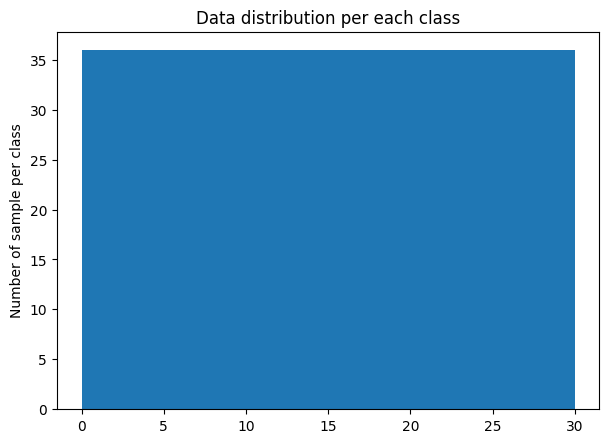

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams.update({
    'figure.figsize':(7,5), 
    'figure.dpi':100
})

# Plot Histogram 
plt.hist(train_set.classes, bins=31)
plt.gca().set(title='Data distribution per each class', ylabel='Number of sample per class');

### VISUALIZE A SAMPLE OF THE TRAINING SET

Let's check a sample from the data set. As we mentioned before, the dataset contains some samples which have been preprocessed using image processing techniques.

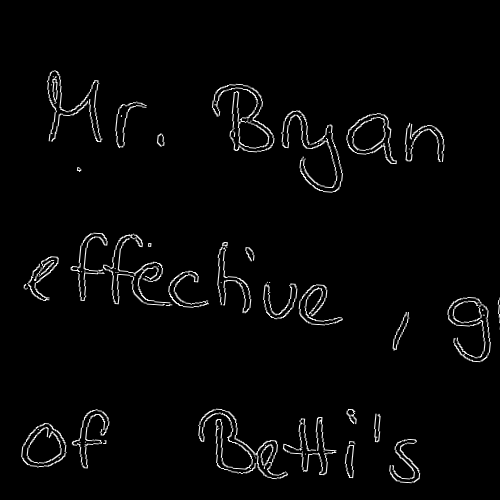

In [24]:
keras.preprocessing.image.array_to_img(
    train_set[0][0][25] 
)

## MODEL ARCHITECTURE AND TRAINING
While deep learning is certainly not new, it is experiencing explosive growth because of the intersection of deeply layered neural networks and the use of GPUs to accelerate their execution.

---
We decide to create a deep architecure to be able to train a model with good accuracy. To do so we are going to take the most use out of some callback function in the keras api.
- <b>`ModelCheckpoint`</b> 🏁: callback is used in conjunction with training using `model.fit()` to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.

- <b>`EarlyStopping` </b>🚦: Assuming the goal of a training is to minimize the loss. With this, the metric to be monitored would be `loss`, and mode would be `min`. A `model.fit()` training loop will check at end of every epoch whether the `loss` is no longer decreasing, considering the `min_delta` and patience if applicable. Once it's found no longer decreasing,the training terminates.

- <b> `ReduceLROnPlateau` </b> 𒑈: Models often benefit from reducing the learning rate by a factor of 2-10 once learning decreases. This callback monitors a quantity and if no improvement is seen for a `patience` number of epochs, the learning rate is reduced.


In [28]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

In [29]:
# reduces learning rate if no improvement are seen
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=1,
                                            verbose=0,
                                            factor=0.2,
                                            min_lr=0.000001)

# stop training if no improvements are seen
early_stop = EarlyStopping(monitor="val_loss",
                            mode="min",
                            patience=3,
                            restore_best_weights=True)

# saves model weights to file
checkpoint = ModelCheckpoint(os.path.join('/content/gdrive/MyDrive/biometric_project/model', 'cp-{epoch:04d}.h5'),
                            monitor='val_loss',
                            verbose=0,
                            save_best_only=True,
                            mode='min',
                            save_weights_only=True)


### MODEL ARCHITECTURE

*   contains 4 convolutional layers
*   2 dense layers
*   and an output (classification) layer

Later on we will remove the classification layer in order to access the feature extraction layers.



In [30]:
from keras import models, layers

model = models.Sequential()

################################.    1st CONVOLUTIONAL LAYER     ################################

model.add(layers.Conv2D(filters=32, input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), kernel_size=(7,7),strides=(2,2), padding='valid'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
model.add(layers.BatchNormalization()) # Batch Normalisation before passing it to the next layer

################################.    2nd CONVOLUTIONAL LAYER     ################################

model.add(layers.Conv2D(filters=64, kernel_size=(5,5), strides=(2,2), padding='valid'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
model.add(layers.BatchNormalization())

################################.    3rd CONVOLUTIONAL LAYER     ################################

model.add(layers.Conv2D(filters=96, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
model.add(layers.BatchNormalization())

################################.    4th CONVOLUTIONAL LAYER     ################################

model.add(layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), padding='valid'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
model.add(layers.BatchNormalization())

################################    FLATTEN, FOR DENSE LAYER     ################################

model.add(layers.Flatten())

################################.    DENSE LAYERS: 1st LAYER     ################################

model.add(layers.Dense(256, input_shape=(IMAGE_SIZE * IMAGE_SIZE * 3,)))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.4))
model.add(layers.BatchNormalization())

################################.    DENSE LAYERS: 2nd LAYER     ################################

model.add(layers.Dense(256))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.4))
model.add(layers.BatchNormalization())


################################.    OUTPUT LAYER: CLASSES    ################################

model.add(layers.Dense(N_CLASSES))
model.add(layers.Activation('softmax'))

### MODEL SUMMARY

Let's check the description of the model architecture and compile the model.

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 247, 247, 32)      4736      
                                                                 
 activation (Activation)     (None, 247, 247, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 123, 123, 32)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 123, 123, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        51264     
                                                                 
 activation_1 (Activation)   (None, 60, 60, 64)        0

In [32]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

### TRAINING

We are ready to start the training phase. But one to mention is that we have two different types of datasets. One is with more augmentation options and the other is considered only the rotation with 10 degrees.
The result of the two models will be saved to the different directories in our google drive. 

Later on, during the evaluation, we will analyze them.

In [ ]:
# Only Rotation
history = model.fit(
    x=train_set,
    validation_data=val_set,
    epochs=150,
    validation_steps=len(val_set),
    steps_per_epoch=len(train_set),
    verbose=1,
    callbacks=[checkpoint, early_stop, learning_rate_reduction],
    )

Epoch 1/150
35/35 [==============================] - 84s 2s/step - loss: 4.0979 - accuracy: 0.0394 - val_loss: 8.7130 - val_accuracy: 0.0323 - lr: 0.0100
Epoch 2/150
35/35 [==============================] - 62s 2s/step - loss: 3.7799 - accuracy: 0.0681 - val_loss: 6.5134 - val_accuracy: 0.0484 - lr: 0.0100
Epoch 3/150
35/35 [==============================] - 60s 2s/step - loss: 3.4326 - accuracy: 0.1039 - val_loss: 5.2381 - val_accuracy: 0.0403 - lr: 0.0100
Epoch 4/150
35/35 [==============================] - 61s 2s/step - loss: 3.1218 - accuracy: 0.1371 - val_loss: 4.2259 - val_accuracy: 0.0887 - lr: 0.0100
Epoch 5/150
35/35 [==============================] - 60s 2s/step - loss: 2.8941 - accuracy: 0.1774 - val_loss: 2.9848 - val_accuracy: 0.1532 - lr: 0.0100
Epoch 6/150
35/35 [==============================] - 65s 2s/step - loss: 2.7628 - accuracy: 0.1935 - val_loss: 2.7257 - val_accuracy: 0.2339 - lr: 0.0100
Epoch 7/150
35/35 [==============================] - 61s 2s/step - loss: 2.5

In [ ]:
# Rotation, shift, brightness, zoomng, rescale augmentation

history = model.fit(
    x=train_set_solo_rotation,
    validation_data=val_set_solo_rotation,
    epochs=150,
    validation_steps=len(val_set),
    steps_per_epoch=len(train_set),
    verbose=1,
    callbacks=[checkpoint, early_stop, learning_rate_reduction],
    )

Epoch 1/150
93/93 [==============================] - 202s 2s/step - loss: 3.4450 - accuracy: 0.1979 - val_loss: 5.8160 - val_accuracy: 0.0345 - lr: 0.0100
Epoch 2/150
93/93 [==============================] - 193s 2s/step - loss: 2.7772 - accuracy: 0.3075 - val_loss: 2.6393 - val_accuracy: 0.3292 - lr: 0.0100
Epoch 3/150
93/93 [==============================] - 187s 2s/step - loss: 2.5467 - accuracy: 0.3283 - val_loss: 2.1448 - val_accuracy: 0.3918 - lr: 0.0100
Epoch 4/150
93/93 [==============================] - 187s 2s/step - loss: 2.2741 - accuracy: 0.3632 - val_loss: 1.7951 - val_accuracy: 0.4451 - lr: 0.0100
Epoch 5/150
93/93 [==============================] - 192s 2s/step - loss: 2.1004 - accuracy: 0.3918 - val_loss: 1.6411 - val_accuracy: 0.5110 - lr: 0.0100
Epoch 6/150
93/93 [==============================] - 189s 2s/step - loss: 1.9381 - accuracy: 0.4173 - val_loss: 1.5332 - val_accuracy: 0.5298 - lr: 0.0100
Epoch 7/150
93/93 [==============================] - 188s 2s/step - lo

### LOSS/ACCURACY VISUALIZATION
In the following, you can see the figures corresponding to the training loss and validation loss.

The next figure represents the accuracy of the validation and training set. 

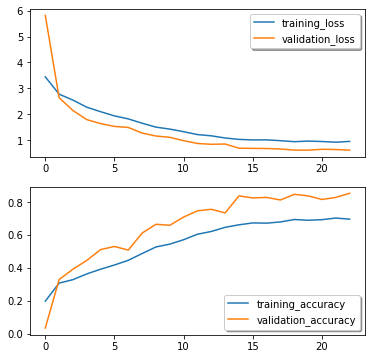

In [ ]:
import matplotlib.pyplot as plt

# plot training history
_, ax = plt.subplots(2, 1, figsize=(6, 6))
ax[0].plot(history.history['loss'], label="training_loss")
ax[0].plot(history.history['val_loss'], label="validation_loss")
ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], label="training_accuracy")
ax[1].plot(history.history['val_accuracy'], label="validation_accuracy")
ax[1].legend(loc='best', shadow=True)

plt.show()

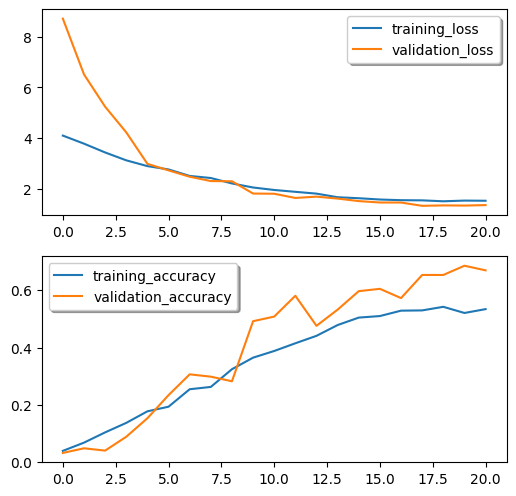

In [ ]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(2, 1, figsize=(6, 6))

# plot training and validation loss
ax[0].plot(history.history['loss'], label="training_loss")
ax[0].plot(history.history['val_loss'], label="validation_loss")
ax[0].legend(loc='best', shadow=True)

# plot training and validation accuracy
ax[1].plot(history.history['accuracy'], label="training_accuracy")
ax[1].plot(history.history['val_accuracy'], label="validation_accuracy")
ax[1].legend(loc='best', shadow=True)

plt.show()

---

## TEST SET ACCURACY

We are going to load our test set in order to test the model performance and see the result on some samples.
The first thing needed is to load the test set.

In [161]:
data_generator_test_set = keras.preprocessing.image.ImageDataGenerator()
test_set = data_generator_test_set.flow_from_directory(
    os.path.join('/content', 'test_set'), 
    target_size=IMAGE_SHAPE, 
    batch_size=BATCH_SIZE, 
    class_mode='categorical',
)

Found 372 images belonging to 31 classes.


### SOME FUNCTIONS
In the following two different function has been defined in order to test some samples from the test set



In [151]:
THRESHOLD = 0.04

In [152]:
def apply_threshold(dic, threshold=THRESHOLD):
    
    for (key, value) in dic:
        if value >= threshold:
            print(f'author id: {key} ----------> score: {str(value*100)}%')

In [157]:
import numpy as np
from keras.preprocessing.image import img_to_array, load_img

classes = val_set.class_indices

def test_on_a_image(path):
  test_image = img_to_array(load_img(path, target_size = (IMAGE_SIZE, IMAGE_SIZE)))
  result = model.predict(np.expand_dims(test_image, axis = 0))
  dic = {}
  for (key, value) in classes.items():
      dic[key] = float(format(result[0][value],'.5f'))

  return apply_threshold(sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10])

### TEST SET ACCURACY: Model With Rotation Only
Let's evaluation the first model and see some examples tested on some samples taken from the test_set

In [118]:
model.load_weights('/content/gdrive/MyDrive/biometric_project/model_solo_rotation/cp-0016.h5')

In [119]:
loss, acc = model.evaluate(test_set)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

12/12 [==============================] - 13s 1s/step - loss: 1.8915 - accuracy: 0.4489
Restored model, accuracy: 44.89%


In [158]:
test_on_a_image('/content/test_set/0/a01-007u-0.png')

author id: 0 ----------> score: 79.88199999999999%
author id: 346 ----------> score: 9.014999999999999%
author id: 348 ----------> score: 4.9%


In [148]:
test_on_a_image('/content/test_set/344/g06-011m-0.png')

author id: 153 ----------> score: 63.247%
author id: 344 ----------> score: 12.092%
author id: 634 ----------> score: 12.011%
author id: 346 ----------> score: 4.833%


In [149]:
test_on_a_image('/content/test_set/155/c03-000f-1.png')

author id: 155 ----------> score: 60.33%
author id: 150 ----------> score: 7.619%
author id: 384 ----------> score: 6.5009999999999994%
author id: 342 ----------> score: 4.027%


In [150]:
test_on_a_image('/content/test_set/336/g06-011e-2.png')

author id: 336 ----------> score: 37.208000000000006%
author id: 333 ----------> score: 10.807%
author id: 634 ----------> score: 9.17%
author id: 346 ----------> score: 8.997%
author id: 347 ----------> score: 6.76%
author id: 342 ----------> score: 5.318%
author id: 153 ----------> score: 5.108%
author id: 635 ----------> score: 4.531000000000001%


### TEST SET ACCURACY: Model With more augmentation
Let's evaluation the second model and see some examples tested on some samples taken from the test_set

In [187]:
model.load_weights('/content/gdrive/MyDrive/biometric_project/model_full_aug/cp-0018.h5')

In [ ]:
loss, acc = model.evaluate(test_set)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

12/12 [==============================] - 18s 1s/step - loss: 1.3178 - accuracy: 0.6317
Restored model, accuracy: 63.17%


In [189]:
test_on_a_image('/content/test_set/0/a01-007u-0.png')

author id: 0 ----------> score: 99.947%


In [190]:
test_on_a_image('/content/test_set/344/g06-011m-0.png')

author id: 346 ----------> score: 78.269%
author id: 153 ----------> score: 11.905000000000001%
author id: 634 ----------> score: 7.295999999999999%


In [191]:
test_on_a_image('/content/test_set/155/c03-000f-1.png')

author id: 155 ----------> score: 86.467%
author id: 0 ----------> score: 6.039%


In [192]:
test_on_a_image('/content/test_set/336/g06-011e-2.png')

author id: 0 ----------> score: 47.239%
author id: 346 ----------> score: 21.458%
author id: 336 ----------> score: 20.237%


### OBSERVATION

- While the first model shows more author scores and is less sure about them, the second model is more strict to the final list. That makes the second model make more mistakes about the prediction.

- While with the first model we use fewer augmentation options the result is more acceptable than the second one. Of course, these are just personal observations. To better analyze the system, we must perform a full biometric evaluation task.

## FEATURE EXTRACTOR MODEL

As you can see we have two different classification models that are able to classify an image among 31 different authors. But In biometrics, we need feature extractor modules in order to create and extract the relevant features during the enrollment and save them in our gallery.
Therefore, what we are going to do is to remove the last layer of our model which is the classification layer in order to access the feature layer.

In [208]:
last_feature_layer = model.get_layer(index=24).output

In [209]:
feature_extractor = keras.Model(
    inputs = model.input,
    outputs = last_feature_layer
)

feature_extractor.compile(optimizer=keras.optimizers.Adam(0.02),
            loss='categorical_crossentropy',
            metrics=['accuracy'])